## Transformer-based What-if Scenario Generation (TBWISA)
---

### 1. TBWISA Framework

...

---

### 2. Exploratory Data Analysis

...

#### 2.1. Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from source.scenario_generation import ScenarioGeneration

from nixtla import NixtlaClient

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term
/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [ ]:
# Export python packages
#!pip freeze > ../requirements.txt
#!conda list -e > ../requirements.txt

In [ ]:
#TODO: write a function to load the data

#### 2.2. Config parameters

Forecasting models:

- sarimax:
- transformer:
- autots
- timegpt

In [ ]:
# Dataset specific parameters
time_unit = 'month'
item_id = "item_100"            # "item_058" (used in the report)
store_id = "store_001"
price_change_percentages = [-20, -10, 10, 20]
forecast_length = 12

# Model specific parameters
forecast_model = "transformer"  # The forecasting model selected
max_window_size = 3             # Window size in time steps for the optimal window

# Transformer parameters
simulation_size = 1             # 10
num_layers = 8                  # 8
size_layer = 128                # 128
epoch = 100                     # 500
dropout_rate = 0.8              # 0.8
learning_rate = 0.001           # 0.001
batch_size = 5                  # 5

#### 2.3. Load data

In [5]:
# Load Data
def load_data(file_path):
    """Load historical data from a CSV file."""
    data = pd.read_csv(file_path, parse_dates=True, index_col='timestamp')
    return data

In [ ]:
# Load dataset

# Target time series:   https://github.com/aws-samples/amazon-forecast-samples/blob/main/library/content/TargetTimeSeries.md
file_path_tts = '../dataset/consumer_electronics_TTS.csv'
# Related time series:  https://github.com/aws-samples/amazon-forecast-samples/blob/main/library/content/RelatedTimeSeries.md
file_path_rts = '../dataset/consumer_electronics_RTS.csv'

data_tts = load_data(file_path_tts)
data_rts = load_data(file_path_rts)

# Dataset transformations
data_merged = pd.merge(data_rts, data_tts, on=['timestamp','item_id', 'store_id'], how='left')
data_all = data_merged[(data_merged["item_id"] == item_id) & (data_merged["store_id"] == store_id)]
data = data_all[:-3]

In [44]:
data

,item_id,store_id,price,demand,revenue
timestamp,,,,,
2017-10-01,item_100,store_001,92.000000,337.382722,31039.210406
2017-11-01,item_100,store_001,92.000000,348.048235,32020.437638
2017-12-01,item_100,store_001,92.000000,345.839263,31817.212178
2018-01-01,item_100,store_001,92.000000,331.347697,30483.988124
2018-02-01,item_100,store_001,86.758910,336.825214,29222.588448
2018-03-01,item_100,store_001,86.758910,309.354445,26839.254405
2018-04-01,item_100,store_001,80.992152,317.936678,25750.375633
2018-05-01,item_100,store_001,82.174517,298.464994,24526.216888
2018-06-01,item_100,store_001,101.424018,219.573024,22269.978406


#### 2.4. Data Exploration

Correlation between price and demand time series

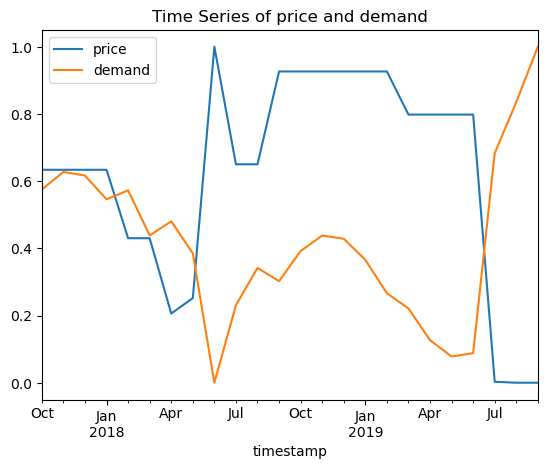

In [45]:
# Plot the time series of price and demand

filtered_data = data[["price", "demand"]]
#normalized_df=(filtered_data - filtered_data.mean()) / filtered_data.std()
normalized_df=(filtered_data-filtered_data.min())/(filtered_data.max()-filtered_data.min())

normalized_df.plot(title='Time Series of price and demand')
plt.show()

In [9]:
# Calculate the correlation between the two time series
correlation = data['price'].corr(data['demand'])
print(f"Correlation between Price and demand: {correlation:.2f}")

Correlation between Price and demand: -0.72


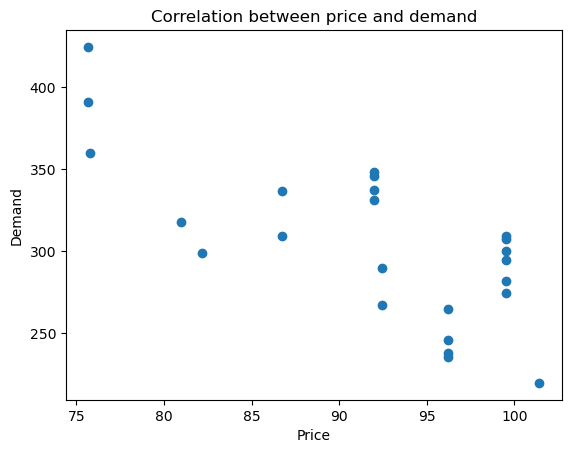

In [10]:
# Plot the scatter plot to visualize correlation
plt.scatter(data['price'], data['demand'])
plt.title(f'Correlation between price and demand')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.show()

---

### 3. Model Construction

...

In [11]:
from source.scenario_generation import ScenarioGeneration
scenario_generator = ScenarioGeneration(forecast_model, num_layers, size_layer, batch_size, epoch, dropout_rate, forecast_length, learning_rate, simulation_size)

Init transformer


#### 3.1. Baseline forcast

Forecasting the **price** ...

In [12]:
%%time

baseline_price = scenario_generator.forecast(data['price'], model=forecast_model, steps=forecast_length)
baseline_price.loc[data.index[-1]] = data["price"][-1]
baseline_price.sort_index(inplace=True)

Init transformer
simulation 1
Instructions for updating:
Use `tf.cast` instead.


/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
Instructions for updating:
Use `tf.cast` instead.
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers.dense(queries, num_units, name='Q')
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:151: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.la

CPU times: user 2.34 s, sys: 548 ms, total: 2.89 s
Wall time: 1.69 s


In [13]:
baseline_price

,value
timestamp,
2019-09-01,75.693517
2019-10-01,88.261478
2019-11-01,83.041793
2019-12-01,76.460287
2020-01-01,79.627641
2020-02-01,82.924014
2020-03-01,82.064635
2020-04-01,76.694713
2020-05-01,73.741346


Forecasting the **demand** ...

In [14]:
%%time

baseline_demand = scenario_generator.forecast(data['demand'], model=forecast_model, steps=forecast_length)

baseline_demand.loc[data.index[-1]] = data["demand"][-1]
baseline_demand.sort_index(inplace=True)

/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers.dense(queries, num_units, name='Q')
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:151: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.layers.dense(keys, 2*num_units, name='K_V')
/Users/a

Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 86.44it/s, acc=94.1, cost=0.00747]


CPU times: user 1.91 s, sys: 500 ms, total: 2.41 s
Wall time: 1.57 s


#### 3.2. Scenario generation

**Create** the scenarios ...

In [15]:
# Generate scenarios
scenarios, adjusted_input = scenario_generator.generate_scenarios(data, price_change_percentages)

**Forecasting** values of *price* for each scenario ...

In [16]:
%%time

# Apply scenarios and forecast
forecasted_price = scenario_generator.apply_scenarios(data, adjusted_input, "price", model=forecast_model, forecast_horizon=forecast_length)
forecasted_price["Baseline"] = baseline_price

/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers.dense(queries, num_units, name='Q')
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:151: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.layers.dense(keys, 2*num_units, name='K_V')
/Users/a

Scenario Price Change -20%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 82.72it/s, acc=92, cost=0.0183] 
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense

Scenario Price Change -10%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 77.01it/s, acc=90.6, cost=0.0214]
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dens

Scenario Price Change 10%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 84.25it/s, acc=87.3, cost=0.0348]
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dens

Scenario Price Change 20%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 83.99it/s, acc=90.8, cost=0.0206]


CPU times: user 7.8 s, sys: 2.17 s, total: 9.98 s
Wall time: 6.58 s


**Forecasting** values of *demand* for each scenario ...

In [17]:
%%time

# Apply scenarios and forecast
forecasted_demand = scenario_generator.apply_scenarios(data, scenarios, "demand", model=forecast_model, forecast_horizon=forecast_length)
forecasted_demand["Baseline"] = baseline_demand

/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers.dense(queries, num_units, name='Q')
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:151: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.layers.dense(keys, 2*num_units, name='K_V')
/Users/a

Scenario Price Change -20%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 86.94it/s, acc=94.2, cost=0.00681]
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.den

Scenario Price Change -10%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 84.81it/s, acc=93.3, cost=0.00967]
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.den

Scenario Price Change 10%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 84.05it/s, acc=91.6, cost=0.0158]
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dens

Scenario Price Change 20%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 84.31it/s, acc=95.1, cost=0.00529]


CPU times: user 7.63 s, sys: 2.11 s, total: 9.74 s
Wall time: 6.33 s


---

### 4. Model Evaluation

...

In [18]:
# ...

---

### 5. Model Results

...

#### 5.1. Forecasting

...

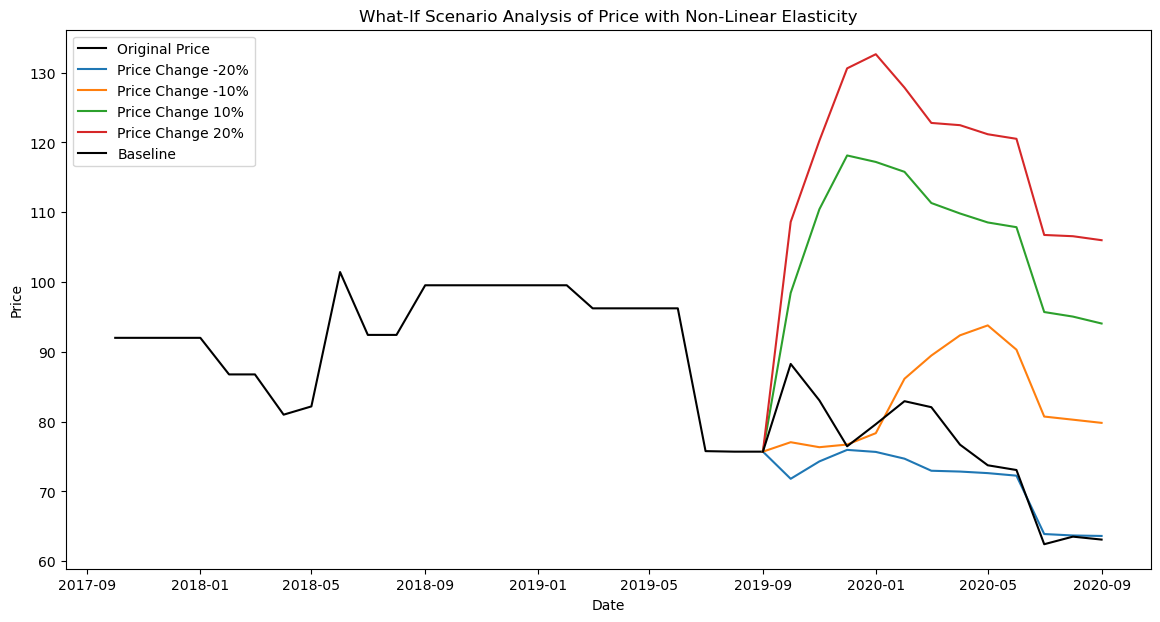

In [19]:
# Visualize the results
scenario_generator.visualize_results(data['price'], forecasted_price, "Price")

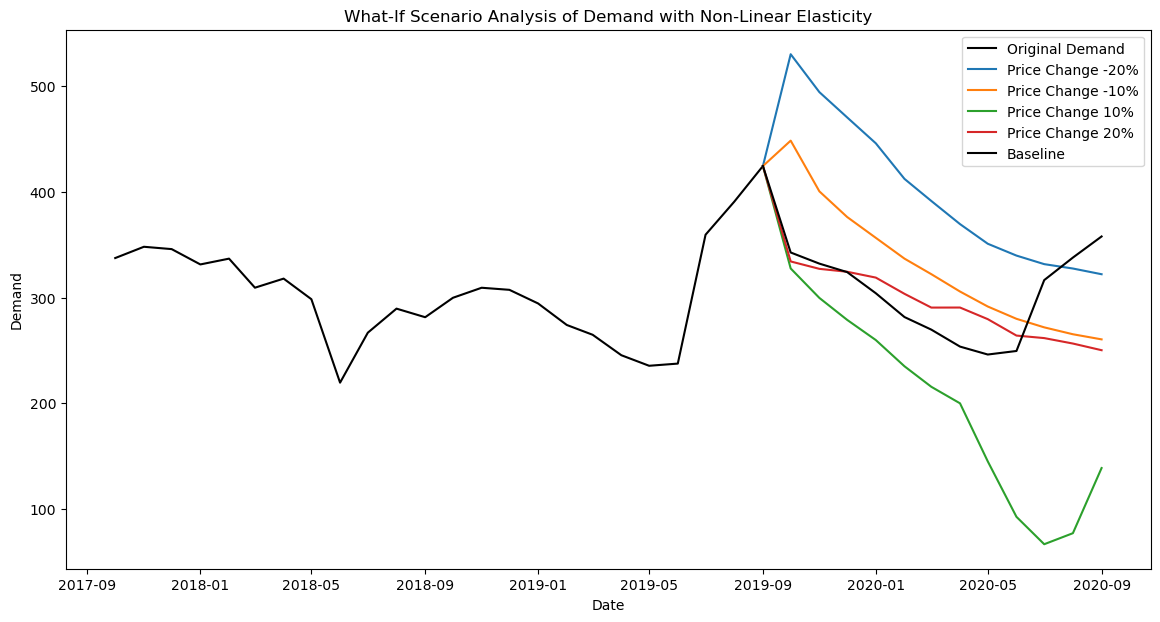

In [20]:
# Visualize the results
scenario_generator.visualize_results(data['demand'], forecasted_demand, "Demand")

#### 5.2. Results

Total **revenue** ...

In [21]:
# Calculate revenue

data['revenue'] = data['price'] * data['demand']

forecasted_revenue = {}
total_revenue = {}
for price_scenario, demand_df in forecasted_demand.items():
    demand_df = pd.DataFrame(demand_df)
    price_df = pd.DataFrame(forecasted_price.get(price_scenario))
    if price_df is not None:
        #revenue_df = demand_df * price_df
        revenue_df = pd.DataFrame(demand_df.values*price_df.values, columns=demand_df.columns, index=demand_df.index)
        forecasted_revenue[price_scenario] = revenue_df
        total_revenue[price_scenario] = revenue_df.sum().values[0]

for scenario, total_rev in total_revenue.items():
    print(f"{scenario} - Total Revenue: {total_rev:.2f}")

Price Change -20% - Total Revenue: 375178.50
Price Change -10% - Total Revenue: 356755.12
Price Change 10% - Total Revenue: 286604.03
Price Change 20% - Total Revenue: 450007.97
Baseline - Total Revenue: 304060.17


/var/folders/lj/dwbsfn1d6k592c_f3y7j6xmm0000gn/T/ipykernel_63039/1985620381.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['revenue'] = data['price'] * data['demand']


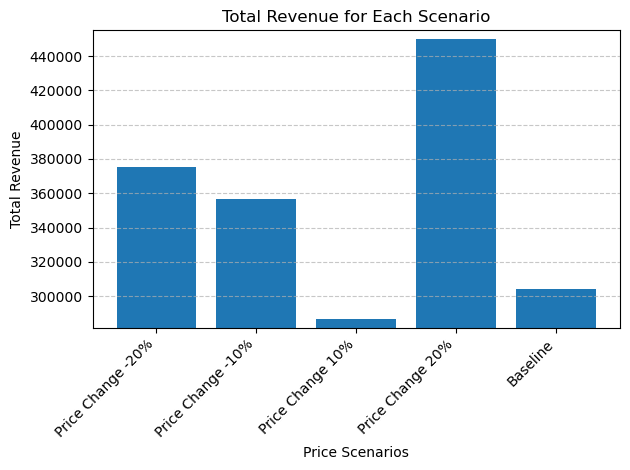

In [22]:
# Plot the total revenue for each scenario
plt.figure()
plt.bar(total_revenue.keys(), total_revenue.values())
plt.ylim([min(total_revenue.values()) - 5000, max(total_revenue.values()) + 5000])
plt.title('Total Revenue for Each Scenario')
plt.xlabel('Price Scenarios')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

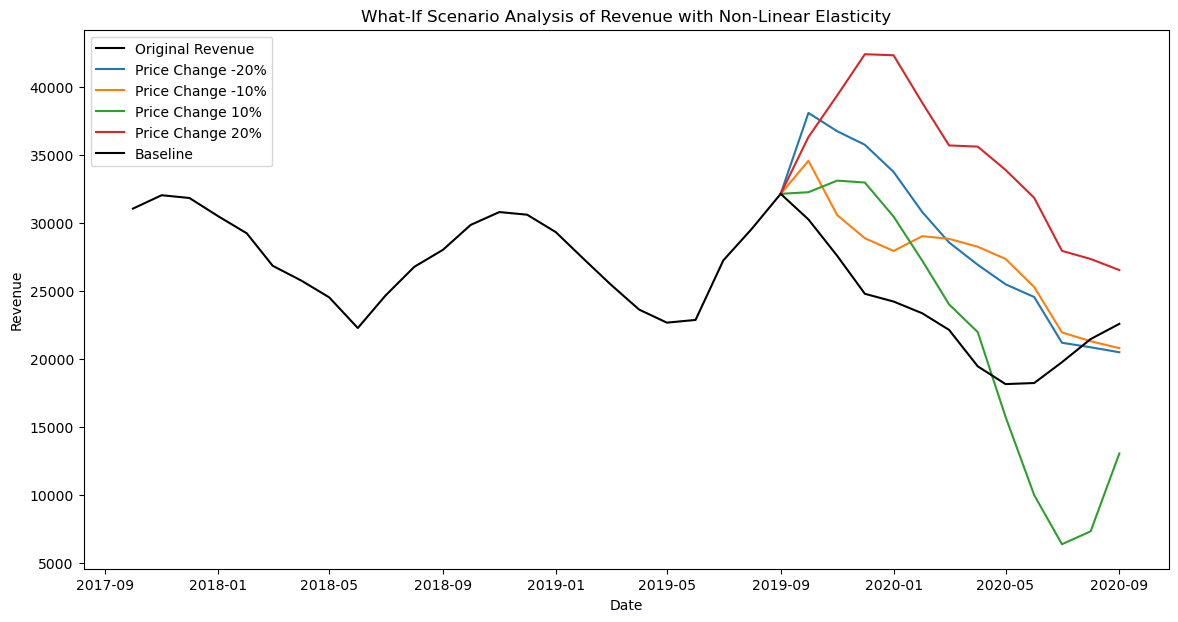

In [23]:
# Visualize the results
scenario_generator.visualize_results(data['revenue'], forecasted_revenue, "Revenue")

#### 5.4. Optimal window

The optimal profit window generation process involves finding a specific time segment within the forecast period that maximizes profit. Instead of assuming that the entire forecast length is optimal, the algorithm identifies the most profitable subset of the forecast, which could vary in size (from as small as one time step to the full forecast length) ...

In [39]:
# Training data preparation with quadratic penalty
max_window_size = 3  # Limit the window size
penalty_factor = 0.05  # Reduced penalty factor for larger windows
X, y = scenario_generator.prepare_training_data_with_quadratic_penalty(forecasted_revenue, max_window_size, penalty_factor)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

Mean Absolute Error: 634.8610285024045
R^2 Score: 0.9988308073954079


Optimal Scenario: Price Change 20%
Window: 3 to 5
Profit: 122323.45


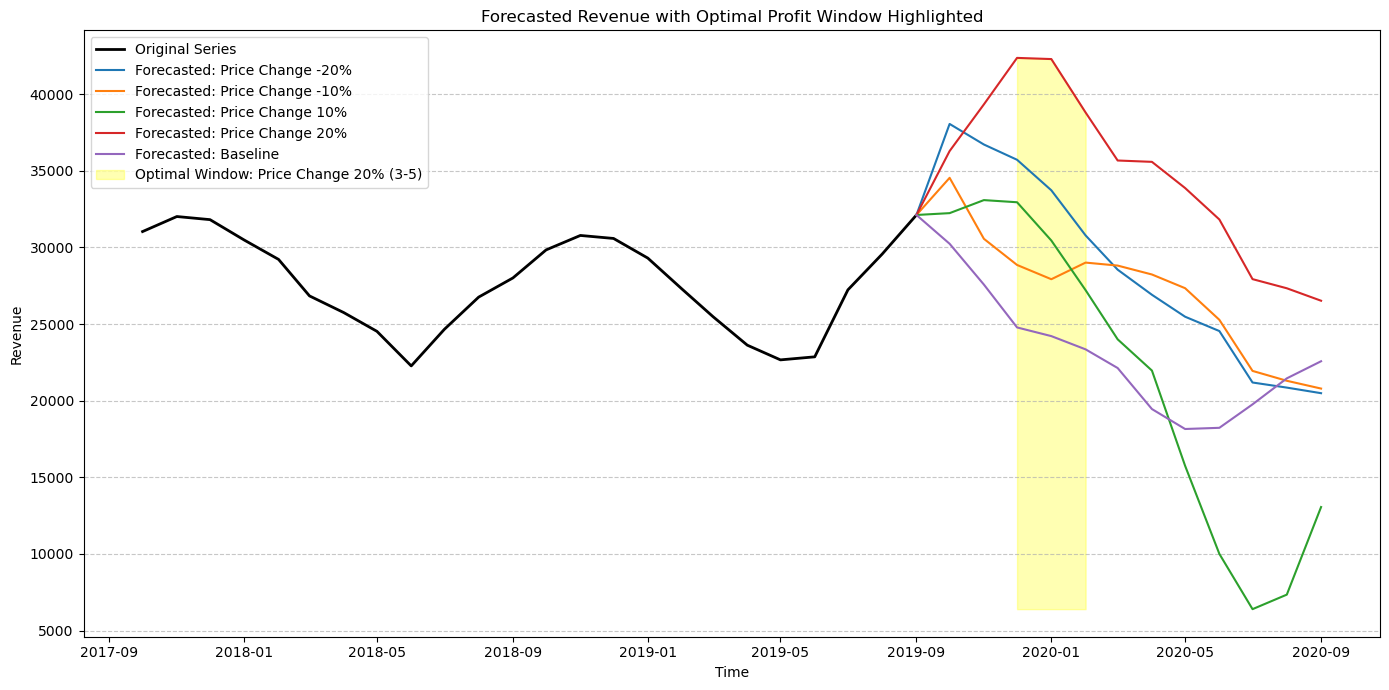

In [40]:
# Determine the optimal window with quadratic penalty
optimal_window_ml = scenario_generator.find_optimal_window_with_quadratic_penalty(forecasted_revenue, model, max_window_size, penalty_factor)
print(f"Optimal Scenario: {optimal_window_ml['scenario']}")
print(f"Window: {optimal_window_ml['start_index']} to {optimal_window_ml['end_index']}")
print(f"Profit: {optimal_window_ml['profit']:.2f}")

# Assuming you have a DataFrame `original_series` and a dictionary `forecasted_revenue` with the optimal result
scenario_generator.visualize_optimal_window_with_history(data['revenue'], forecasted_revenue, optimal_window_ml)

---

### Conclusions

...